In [11]:
from src.load_data import get_data
from src.EchoGAE import EchoGAE_algorithm

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

import numpy as np
import random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# KMeans
from sklearn.cluster import KMeans

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

In [12]:
def plot_ideology(real, pred, save = False, name = None):
    fig = plt.subplots(figsize=(10, 7.5))
    fig1 = sns.histplot(real, label='Real ideology scores', bins=30, kde=True, color='crimson', element="step")
    fig2 = sns.histplot(pred, label='Predicted ideology scores' , bins=30, kde=True, element="step", color = 'teal')
    plt.legend()
    
    if name is not None:
        plt.savefig(name)


def ideology_detection(user_embeddings: np.ndarray) -> np.ndarray:
    distances = None
    cluster_label = None

   
    distances = euclidean_distances(user_embeddings)

    cluster_label = KMeans(n_clusters=2, random_state=42).fit_predict(user_embeddings)
    

    user_ideology_scores = []
    for i in range(len(distances)):
        user_ideology_scores.append(
            distances[i][cluster_label == 0].mean()
            - distances[i][cluster_label == 1].mean()
        )
    user_ideology_scores = np.array(user_ideology_scores)

    # Normalize the polarization between -1 and 1
    min_score = user_ideology_scores.min()
    max_score = user_ideology_scores.max()

    user_ideology_scores = (user_ideology_scores - min_score) / (max_score - min_score)
    user_ideology_scores = user_ideology_scores * 2 - 1

    return user_ideology_scores



def select_10_percent(dictionary):
    num_items = len(dictionary)
    num_to_select = int(num_items * 0.1)
    selected_items = random.sample(list(dictionary.items()), num_to_select)
    return dict(selected_items)

MAE: 0.274 -- MSE: 0.125
MAE: 0.317 -- MSE: 0.169
MAE: 0.352 -- MSE: 0.228
MAE: 0.287 -- MSE: 0.141


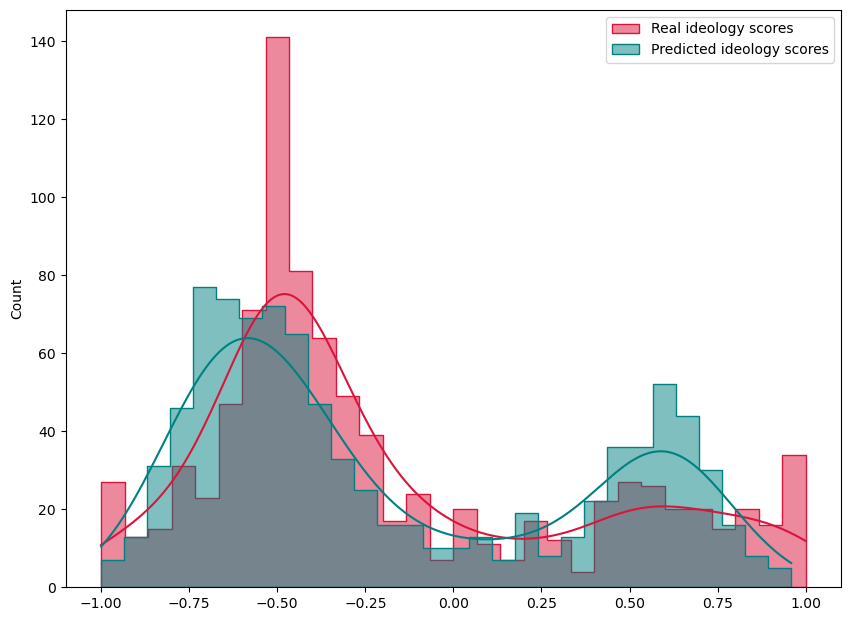

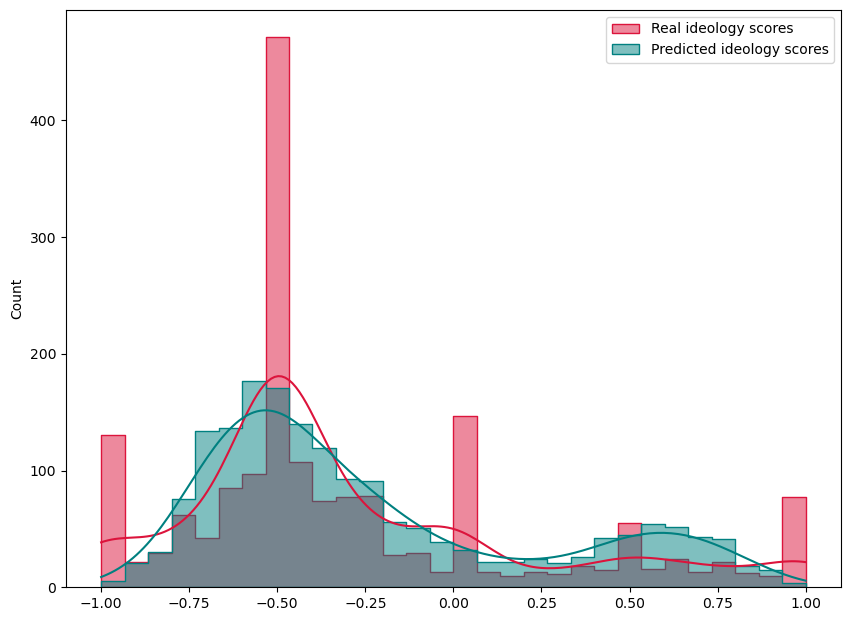

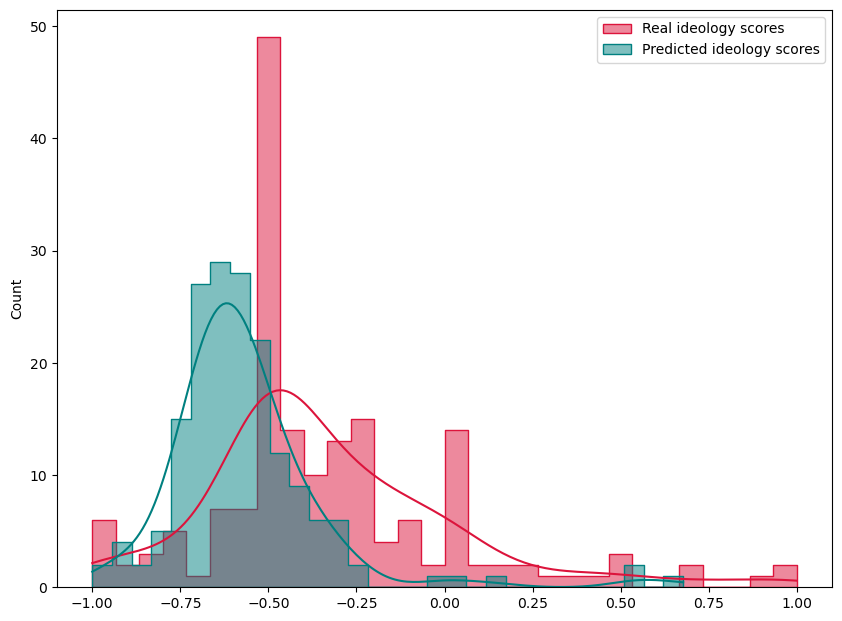

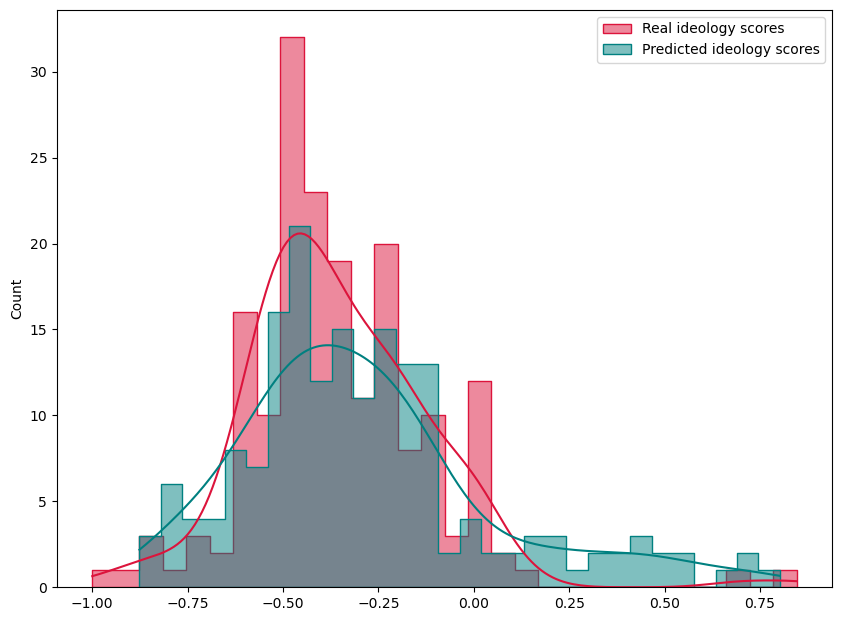

In [13]:
datasets = ["gun", "abortion", "super_bowl", "sxsw"]
experiments = []

for ds in datasets:
    item = {}
    item["dataset"] = ds

    G, users_embeddings, labels, allsides_scores, node_id_map = get_data(f"data/{ds}/")

    train_allsides = select_10_percent(allsides_scores)
    test_allsides = {k: v for k, v in allsides_scores.items() if k not in train_allsides}
    real = list(test_allsides.values())

    # My method
    user_emb = EchoGAE_algorithm(G, user_embeddings= users_embeddings, show_progress=False, hidden_channels = 20, out_channels=10, epochs=300)

    all_ideologies = ideology_detection(user_emb)

    pred = all_ideologies[list(test_allsides.keys())]

    
    my_mae = min(mae(real, pred), mae(real, -1.0 * pred))
    my_mse = min(mse(real, pred), mse(real, -1.0 * pred))

    item["mae"] = my_mae
    item["mse"] = my_mse

    print(f"MAE: {my_mae:.3f}", end=" -- ")
    print(f"MSE: {my_mse:.3f}")

    # Plot
    if mae(real, pred) <= mae(real, -1.0 * pred):
        plot_ideology(real, pred)
    else:
        plot_ideology(real, -1.0 * pred)

    experiments.append(item)

In [14]:
df_idol = pd.DataFrame(experiments)
df_idol

,dataset,mae,mse
0,gun,0.274016,0.125027
1,abortion,0.317013,0.169364
2,super_bowl,0.352395,0.228211
3,sxsw,0.287209,0.140863
